### Problem 3 Kernel PCA

This problem requires you to :

*    Understand how kernelized PCA works 
*    Implement kernel matrix (640 by 640 in this problem)
*    (a) Do spectral analysis over kernel matrix
*    (b) Do projection on your reduced space (where all projection happened in feature space, not original image space)
*    (c) **Hard Part**: Compute what people usually called as **pre-image** or kernel projection, i.e. we want to know the reconstructed image instead of projection result over kernel space.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import os

In [74]:
# Read the data and convert into data matrix X
# This part comes from previous exercise.
num_of_pic = 640;
pixel_size = 50;
filepath = './data'

X = np.zeros((num_of_pic, pixel_size*pixel_size))

for i in range(0,num_of_pic):
    filename = os.path.join(filepath, str(i+1)+".png" )
    A=img.imread(filename)
    X[i,...] = A.reshape((1,-1))

average = np.mean(X,axis=0)
average.shape

(2500,)

Note that $\phi(x_i)$ might not have zero mean, we need to compute covariance matrix using our given formula.

In [75]:
# Now we need to do something different, we need to construct kernel matrix to apply PCA
# We have to apply the formula given in lecture notes to adjust our kernel matrix to make it have zero mean w.r.t. given datas

def Gaussian_kernel(u,v):
    # choose beta=0.001
    return np.exp(-0.001*np.linalg.norm(u-v)**2)

def Polynomial_kernel(u,v):
    # choose d=2
    return (1+np.dot(u,v))**2

gaussK = np.zeros((num_of_pic,num_of_pic))
polyK = np.zeros((num_of_pic,num_of_pic))

# Compute two kernel matrices
for i in range(num_of_pic):
    for j in range(num_of_pic):
        gaussK[i,j]= Gaussian_kernel(X[i,...],X[j,...])
        polyK[i,j]= Polynomial_kernel(X[i,...],X[j,...])

print(gaussK.shape)
J= np.ones((num_of_pic,num_of_pic))*1.0/num_of_pic

# Note J is symmetric, so we do not need transpose here
# Now compute normalized kernel matrices
gaussK0 = np.sum(np.sum(gaussK))/num_of_pic/num_of_pic
polyK0 = np.sum(np.sum(polyK))/num_of_pic/num_of_pic
gaussK = gaussK  - np.matmul(J,gaussK) - np.matmul(gaussK,J) + np.matmul(np.matmul(J,gaussK),J)
polyK = polyK - np.matmul(J,polyK) - np.matmul(polyK,J) + np.matmul(np.matmul(J,polyK),J)

(640, 640)


Note that the complexity for constructing a kernel is $O(m^2)$, where $m$ is the number of samples you have. So if you apply kernel trick to a large dataset, further techniques are needed to maintain time complexity cost here. Before we proceed to next step, we need to define centralized kernel function first.

In [76]:
# Centralized kernel based on dataset
def Gaussian_kernel_centralized(u,v):
    subtraction = 0
    for i in range(num_of_pic):
        subtraction = subtraction + Gaussian_kernel(X[i,:],v) + Gaussian_kernel(u,X[i,:])
    return Gaussian_kernel(u,v) - subtraction / num_of_pic + gaussK0

def Polynomial_kernel_centralized(u,v):
    subtraction = 0
    for i in range(num_of_pic):
        subtraction = subtraction + Polynomial_kernel(X[i,:],v) + Polynomial_kernel(u,X[i,:])
    return Polynomial_kernel(u,v) - subtraction / num_of_pic + polyK0

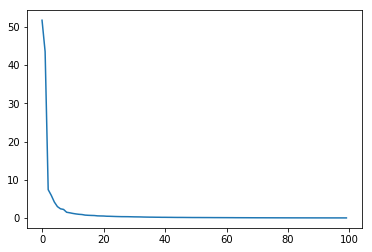

We need 27 eigenfaces for Gaussian Kernel.


In [77]:
# Do spectral analysis over kernelized matrix
# First is Gaussian Kernel
# Note this result depends on the hyperparameter of beta

gaussSigma, gaussV = np.linalg.eig(gaussK)
gaussSigma= gaussSigma.real

sort_perm = gaussSigma.argsort()[::-1]
gaussSigma = np.sort(gaussSigma)[::-1]   
gaussV = gaussV[:, sort_perm]

plt.plot(gaussSigma[0:100])
plt.show()

# Compute how many eigenvalues we need to take 90% sum of eigenvalues
# This shows significant difference between two kernels, along with the PCA we have done before
total = np.sum(gaussSigma)
part = 0
eigenface_num =0
while True:
    part += gaussSigma[eigenface_num]
    eigenface_num += 1
    if part >= 0.90*total:
        break
print("We need {} eigenfaces for Gaussian Kernel.".format(eigenface_num))

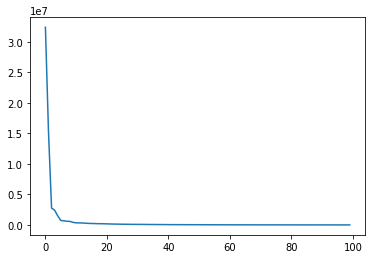

We need 15 eigenfaces for Polynomial Kernel.


In [78]:
# Second is the Polynomial Kernel

polySigma, polyV = np.linalg.eig(polyK)
polySigma= polySigma.real

sort_perm = polySigma.argsort()[::-1]
polySigma = np.sort(polySigma)[::-1]   
polyV = polyV[:, sort_perm]

plt.plot(polySigma[0:100])
plt.show()

# Compute how many eigenvalues we need to take 90% sum of eigenvalues
# This shows significant difference between two kernels, along with the PCA we have done before
total = np.sum(polySigma)
part = 0
eigenface_num =0
while True:
    part += polySigma[eigenface_num]
    eigenface_num += 1
    if part >= 0.90*total:
        break
print("We need {} eigenfaces for Polynomial Kernel.".format(eigenface_num))
k=15

## Find best match image based on similarity norm

For comparison reason, we choose $k=15$ for Polynomial Kernel and $k=30$ for Gaussian Kernel. The projection onto $j$-th principle component is given by:
$$ y_j = \sum_{i=1}^{m} \alpha_{ji} \tilde{K}(x,x_i)$$

The simlarity norm measures $L_2$ error between all vector $y$. Note that $\alpha_{ji}$ need to be normalized with the factor $\sigma_j^{-1/2}$.

In [91]:
def best_match_Gaussian(x,k=30):
    m= num_of_pic;
    
    y=np.zeros((k,))
    # compute projections of x
        
    # compute projections
    for i in range(m):
        kval = Gaussian_kernel_centralized(x,X[i,:])
        for j in range(k):
            # each column is an eigenvector
            y[j]+= gaussV[i,j] * kval/ np.sqrt(gaussSigma[j])
    
    err_list=np.zeros((m,))
    
    # compute projection of each sample and record the similarity norm:
    for i in range(m):
        yj = np.zeros((k,))
        for j in range(k):
            yj[j] = np.dot(gaussK[i,:],gaussV[:,j])/ np.sqrt(gaussSigma[j])
        err_list[i] = np.linalg.norm(y-yj)
        
    idx  =np.argmin(err_list)
    return idx, err_list[idx]
    

def best_match_Polynomial(x,k=100):
    m= num_of_pic;
    
    y=np.zeros((k,))
    # compute projections of x
        
    # compute projections
    for i in range(m):
        kval = Polynomial_kernel_centralized(x,X[i,:])
        for j in range(k):
            # each column is an eigenvector
            y[j]+= polyV[i,j] * kval/ np.sqrt(polySigma[j])
    
    err_list=np.zeros((m,))
    
    # compute projection of each sample and record the similarity norm:
    for i in range(m):
        yj = np.zeros((k,))
        for j in range(k):
            yj[j] = np.dot(polyK[i,:],polyV[:,j])/ np.sqrt(polySigma[j])
        err_list[i] = np.linalg.norm(y-yj)
    idx  =np.argmin(err_list)
    return idx, err_list[idx]
    

In [92]:
def PCA_best_match(filename):
    A = img.imread(filename)
    plt.imshow(A,cmap='gray')
    plt.show()
    x = np.array(A.reshape((1,-1)))
    
    # first: Gaussian Kernel
    idx, err = best_match_Gaussian(x)
    
    print("Gaussian kernal case:\n")
    
    print("Best similar one : No.{}, with error in similarity norm : {}".format(idx+1,err))
    plt.imshow(np.reshape(X[idx,:],(pixel_size,pixel_size)),cmap='gray')
    plt.show()
    print('\n\n')
    
    # second: Polynomial Kernel
    idx, err = best_match_Polynomial(x)
    
    print("Polynomial kernal case:\n")
    
    print("Best similar one : No.{}, with error in similarity norm : {}".format(idx+1,err))
    plt.imshow(np.reshape(X[idx,:],(pixel_size,pixel_size)),cmap='gray')
    plt.show()
    print('\n\n')


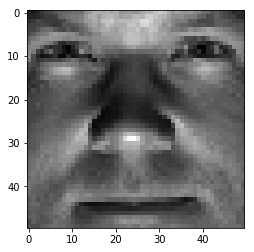

Gaussian kernal case:

Best similar one : No.150, with error in similarity norm : 6.535078577489485e-15


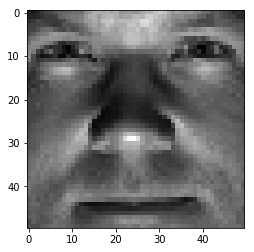




Polynomial kernal case:

Best similar one : No.150, with error in similarity norm : 1.0372344152071704e-11


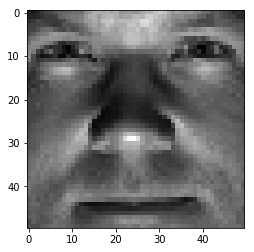

In [93]:
# Now let us test over two pictures
PCA_best_match("PCA_test_1.png")

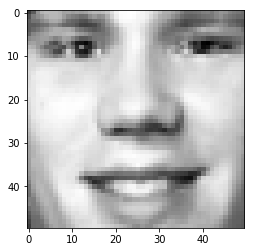

Gaussian kernal case:

Best similar one : No.135, with error in similarity norm : 0.2414776811604959


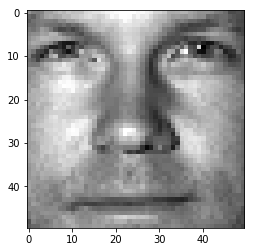




Polynomial kernal case:

Best similar one : No.135, with error in similarity norm : 338.03009409917144


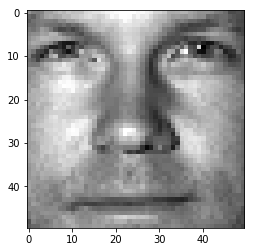

In [94]:
# Now let us test over two pictures
PCA_best_match("PCA_test_2.png")

### Pre-image compuation to approximate reconstructed face in reduced kernel space


Now here comes the problem, given any new image vector, say $x\in \mathbb{R}^{N^2}$, we know its projection on your top-$k$ feature space, $y\in \mathbb{R}^k$, in math, is:
$$  y_j = \phi(x)^T \alpha_j  =\sum_{i=1}^m \alpha_{ji} \tilde{K}(x,x_i),\quad j=1,2,\ldots,k $$

where $\alpha_{ji}$ represents the $i$-th component of $j$-th eigenvector. You can compute this either by the direct form or the matrix form. But this cannot bring you a reconstructed image in the feature space. Now the question is, how can we find the projection of $x$, say $\hat{x}$, given the value of projection to this $k$-dimensional feature space, is known? This can be viewed as a least square problem formulated in the following scheme:

$$\hat{x}=\underset{z\in \mathbb{R}^{N^2}}{argmin}\quad \| \phi(z) - \sum_{j=1}^q y_j v_j\|_2 $$

where $v_j=\sum_{i=1}^m \alpha_{ji} \phi(x_i)$ is the original eigenvalue for covariance matrix $\frac{1}{m}\sum_{i} \phi(x_i)\phi(x_i)^T$. The claim is that if $q$ large enough, this will approximate to 0, so this problems give you an approximation in $L^2$ sense.

In [Mika's paper](https://alex.smola.org/papers/1999/MikSchSmoMuletal99.pdf) and [Kwok's paper](https://www.aaai.org/Papers/ICML/2003/ICML03-055.pdf), thanks to their contribution, we can approximate the solutions for Gaussian and polynomial kernel via iteration scheme:

*    Gaussian: $$z_{t+1}= \frac{\sum_{i=1}^m \gamma_i \tilde{K}(z_t,x_i) x_i}{\sum_{i=1}^m \gamma_i \tilde{K}(z_t,x_i)}$$
where $$\gamma_i = \sum_{j=1}^k y_j \alpha_{ji}$$

*    Polynomial: $$z_{t+1}= \sum_{i=1}^m \gamma_i\left( \frac{z_t^Tx_i+1}{z_t^Tz_t+1}\right)^{d-1} x_i$$
where $\gamma_i$ is same as derivation of Gaussian kernel

These iteration schemes are derived from KKT-condition (by differentiating objective function). But, if you implement this you will find out those methods are very numerically unstable, and hard to converge. Another solution you can propose is to use gradient descent here.


In [95]:
# First compute projections on reduced kernel space (k=15 in both cases)
# For readibility, here we use iteration instead of matrix form

def pre_image_Gaussian(x,k=30):
    m= num_of_pic;
    N= pixel_size*pixel_size;
    
    y=np.zeros((k,))
    # compute projections
    for i in range(m):
        kval = Gaussian_kernel_centralized(x,X[i,:])
        for j in range(k):
            # each column is an eigenvector
            y[j]+= gaussV[i,j] * kval/ np.sqrt(gaussSigma[j])
    
    # compute gamma
    gamma= np.zeros((m,))
    for i in range(m):
        for j in range(k):
            gamma[i]+= y[j]*gaussV[i,j]/ np.sqrt(gaussSigma[j])     
    
    iteration_step = 20;
    prev_z = x
    # compute pre-image
    for t in range(iteration_step):
        t
        denom = 0.0
        z=np.zeros((2500,))
        for i in range(m):
            fraction = gamma[i]* Gaussian_kernel_centralized(prev_z,X[i,:])
            denom += fraction
            z += fraction * X[i,:]
        z /= denom
        prev_z = z
    
    return y,z

In [96]:
# Do same thing but with polynomial kernel
def pre_image_Polynomial(x,k=15):
    m= num_of_pic;
    N= pixel_size*pixel_size;
    
    y=np.zeros((k,))
    # compute projections
    for i in range(m):
        kval = Polynomial_kernel_centralized(x,X[i,...])
        for j in range(k):
            # each column is an eigenvector
            y[j]+= polyV[i,j]*kval/ np.sqrt(polySigma[j])
    
    # compute gamma
    gamma= np.zeros((m,))
    for i in range(m):
        for j in range(k):
            gamma[i]+= y[j]*polyV[i,j]/ np.sqrt(polySigma[j])
            
    iteration_step = 20;
    prev_z = x
    # compute pre-image
    for t in range(iteration_step):
        z=np.zeros((2500,))
        prev_denominator = (np.linalg.norm(prev_z)**2)+1
        for i in range(m):
            # d=2 so d-1=1
            fraction = gamma[i]* (np.inner(prev_z,X[i,...])+1) / prev_denominator
            z += fraction * X[i,...]
        #print(prev_denominator,np.linalg.norm(z))
        prev_z = z
    
    return y,z

In [97]:
def PCA_projection(filename):
    A = img.imread(filename)

    plt.imshow(A,cmap='gray')
    plt.show()
    x = np.array(A.reshape((1,-1)))
    
    # first: Gaussian Kernel
    w, result = pre_image_Gaussian(x)
    
    print("Gaussian kernal case:\n")
    
    # Remember to add average back
    plt.imshow(np.reshape(result,(pixel_size,pixel_size)),cmap='gray')
    plt.show()
    
    # Compute Frobenius error:
    # Or equivallently, L2 norm of falttened vector
    # Or you can calculate RMSE(Root Mean Squared Error)
    err = np.linalg.norm(x-result)
    percent = err*1.0/np.linalg.norm(x)
    print("Frobenius Error is {},in percentage {}%".format(err,percent*100))
    
    rmse = np.sqrt(np.mean((x-result)**2))
    print("RMSE: {}".format(rmse))
    print('\n\n')
    
    # second: Polynomial Kernel
    w, result = pre_image_Polynomial(x)
    
    print("Polynomial kernal case:\n")
    
    # Remember to add average back
    plt.imshow(np.reshape(result,(pixel_size,pixel_size)),cmap='gray')
    plt.show()
    
    # Compute Frobenius error:
    # Or equivallently, L2 norm of falttened vector
    # Or you can calculate RMSE(Root Mean Squared Error)
    err = np.linalg.norm(x-result)
    percent = err*1.0/np.linalg.norm(x)
    print("Frobenius Error is {},in percentage {}%".format(err,percent*100))
    
    rmse = np.sqrt(np.mean((x-result)**2))
    print("RMSE: {}".format(rmse))
    

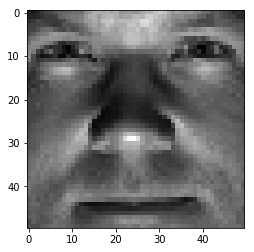

Gaussian kernal case:



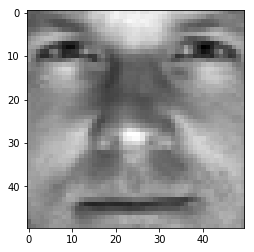

Frobenius Error is 5.078653472505769,in percentage 24.025865106361%
RMSE: 0.10157306945011538



Polynomial kernal case:



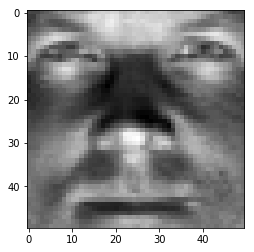

Frobenius Error is 5.733296705829058,in percentage 27.12282182958809%
RMSE: 0.11466593411658114


In [98]:
# Now let us test over two pictures
PCA_projection("PCA_test_1.png")

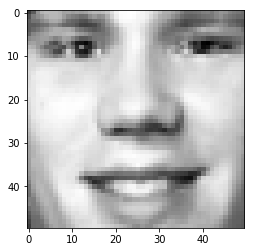

Gaussian kernal case:



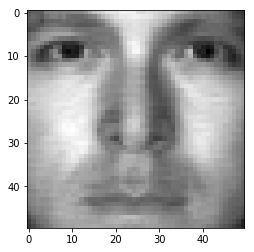

Frobenius Error is 8.531839949560903,in percentage 25.966568466304818%
RMSE: 0.17063679899121803



Polynomial kernal case:



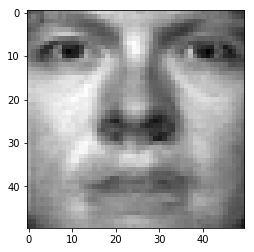

Frobenius Error is 6.557610483308848,in percentage 19.958021083009296%
RMSE: 0.13115220966617697


In [99]:
# Now let us test over two pictures
PCA_projection("PCA_test_2.png")